# Dummy MLP

A multi-layered perceptron (MLP) is a type of neural network that contains at least three layers: an input layer, one or more hidden layers, and an output layer.



The first hidden layer takes inputs from the input layer, processes them using a *non-linear* activation function, and passes them to next hidden layer(s) until the output layer. These non-linear activation functions allow the MLP to learn complex patterns in data.

An MLP consists of at least three layers: an input layer, one or more hidden layers, and an output layer. Each layer contains neurons (or nodes) that are fully connected to the next layer's neurons. This architecture allows MLPs to learn complex patterns in data.

## Import Necessary Packages

In [175]:
import torch
import warnings
import numpy as np
import xarray as xr
import torch.nn as nn
import proplot as pplt
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader
warnings.filterwarnings('ignore')

## Load and Explore Data

We will use an MLP for regression to predict precipitation based on $B_L$. We load in daily-mean precipitation (mm/day) and $B_L$ (m/s<sup>2</sup>) data for the South Asian monsoon region from June-August 2000-2020.

In [176]:
file = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed/LR_ERA5_IMERG_pr_bl_terms.nc'
data = xr.open_dataset(file)
x = data.bl.load()
y = data.pr.load()

We can generate exploratory plots to better understand the distribution of the data, and the relationship between $B_L$ and precipitation.

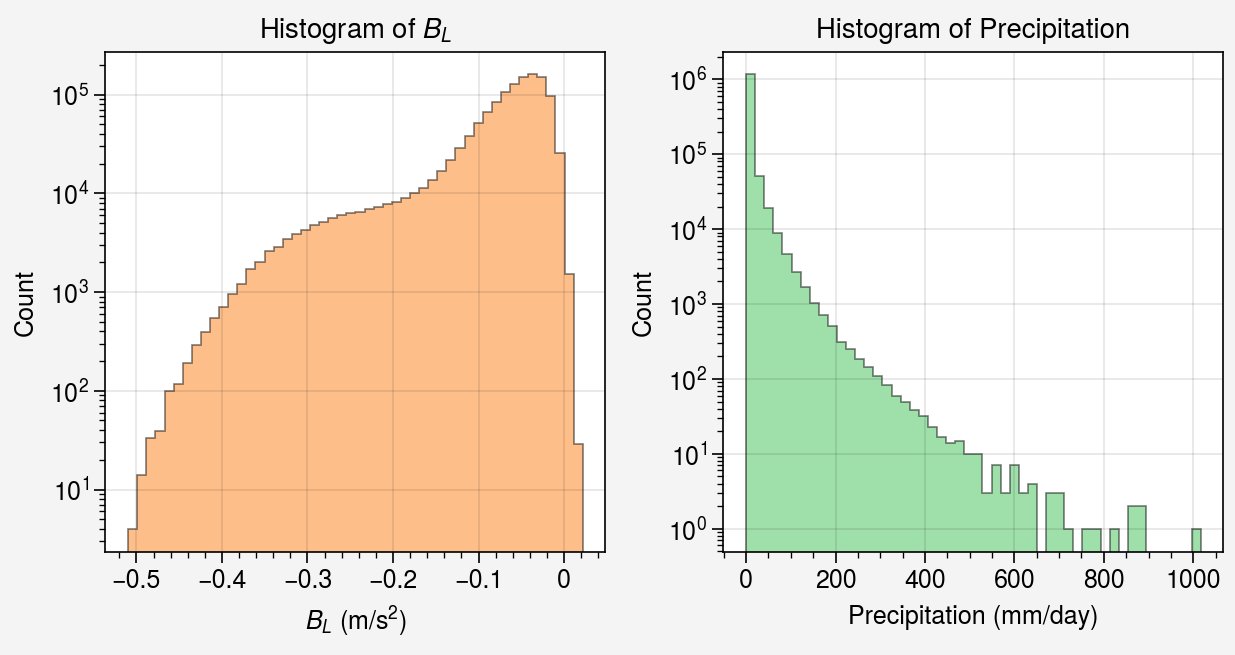

In [177]:
fig,axs = pplt.subplots(nrows=1,ncols=2,sharex=False,sharey=False)
axs.format(ylabel='Count',yscale='log',yformatter='log')
axs[0].format(title='Histogram of $\mathit{B_L}$',xlabel='$\mathit{B_L}$ (m/s$^2$)')
axs[1].format(title='Histogram of Precipitation',xlabel='Precipitation (mm/day)')
axs[0].hist(x.values.flatten(),bins=50,filled=True,color='orange6',edgecolor='k',alpha=0.5)
axs[1].hist(y.values.flatten(),bins=50,filled=True,color='green6',edgecolor='k',alpha=0.5)
pplt.show()

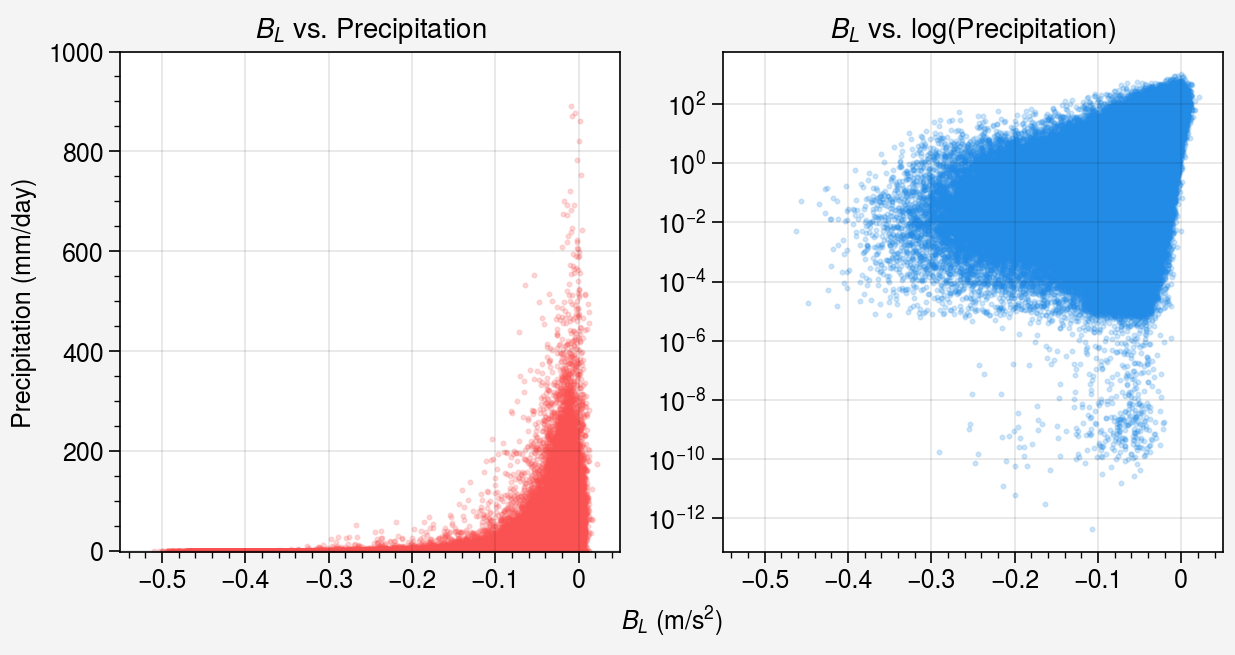

In [178]:
fig,axs = pplt.subplots(nrows=1,ncols=2,sharex=True,sharey=False)
axs.format(xlabel='$\mathit{B_L}$ (m/s$^2$)',xlim=(-0.55,0.05),xticks=0.1)
axs[0].format(title='$\mathit{B_L}$ vs. Precipitation',ylabel='Precipitation (mm/day)',ylim=(-1,1000))   
axs[1].format(title='$\mathit{B_L}$ vs. log(Precipitation)',yscale='log',yformatter='log')   
axs[0].scatter(x.values.flatten(),y.values.flatten(),color='red6',marker='.',markersize=10,alpha=0.2)
axs[1].scatter(x.values.flatten(),y.values.flatten(),color='blue6',marker='.',markersize=10,alpha=0.2)
pplt.show()

## Preprocess the Input and Outputs

The `subset()` function allows us to temporally subset our input (*x*) and output (*y*) data by selecting specific years. It will later be used to divide our data into training and test sets. When dealing with temporal data, you must maintain temporal continuity within each set while ensuring no overlap between them. The splitting method should be carefully selected to ensure a high likelihood of consistent distribution shapes across all sets.

In [179]:
def subset(x,y,startyear,endyear):
    years   = np.arange(startyear,endyear+1)
    xsubset = x.sel(time=x['time.year'].isin(years))
    ysubset = y.sel(time=y['time.year'].isin(years))
    return xsubset,ysubset

The `array()` function reformats our subsetted data to make it compatible with PyTorch. It flattens our 3D Xarray.DataArrays (time × lat × lon) into 1D NumPy arrays. We maintain 64-bit precision during this conversion to ensure accuracy in subsequent processing steps.

In [180]:
def array(xsubset,ysubset):
    return xsubset.values.flatten().astype(np.float64),ysubset.values.flatten().astype(np.float64)

The `normalize()` function applies z-score normalization to our data, centering it around 0 with a standard deviation of 1. It calculates normalization parameters (the mean and standard deviation) if not provided. We typically derive these parameters from the training set and apply them to both the training and test sets. This ensures that the model learns to generalize from the training dat (mitigate overfitting).

In [181]:
def normalize(array,mean=None,std=None):
    if mean is None:
        mean = np.mean(array)
    if std is None:
        std  = np.std(array)
    return (array-mean)/std,mean,std

The `preprocess()` function streamlines our data preparation workflow, combining splitting, array conversion, and normalization steps. A key feature is the log transformation applied to precipitation data, linearizing its exponential relationship with $B_L$. This transformation simplifies the MLP's task, allowing it to predict a linear relationship rather than an exponential one. The function ensures consistent application of normalization parameters derived from the training set to both training and test data. Once the normalization is complete, it converts the NumPy arrays to PyTorch tensors, enabling compatibility with PyTorch's computational framework for subsequent model training and evaluation.

Given that our dataset spans 21 years, we allocate 17 years for training (2000-2016) and 4 years for testing (2017-2020).

In [205]:
def preprocess(x,y,startyear,endyear,ylog=True,training=True,normparams=None):
    xsubset,ysubset = subset(x,y,startyear,endyear)
    xarray,yarray   = array(xsubset,ysubset)
    if training:
        xnorm,xmean,xstd = normalize(xarray)
        ynorm,ymean,ystd = normalize(np.log1p(yarray) if ylog else yarray)
        normparams = {'xmean':xmean,'xstd':xstd,'ymean':ymean,'ystd':ystd,'ylog':ylog}
    else:
        if normparams is None:
            raise ValueError("'normparams' must be provided for validation and test sets.")
        xnorm,_,_ = normalize(xarray,normparams['xmean'],normparams['xstd'])
        ynorm,_,_ = normalize(np.log1p(yarray) if normparams['ylog'] else yarray,normparams['ymean'],normparams['ystd'])
    xtensor = torch.FloatTensor(xnorm)
    ytensor = torch.FloatTensor(ynorm)
    return (xtensor,ytensor,normparams) if training else (xtensor,ytensor)

xtrain,ytrain,normparams = preprocess(x,y,2000,2016,training=True,normparams=False)
xtest,ytest = preprocess(x,y,2017,2020,training=False,normparams=normparams)

xtrain = xtrain.view(-1, 1)
ytrain = ytrain.view(-1, 1)
xtest = xtest.view(-1, 1)
ytest = ytest.view(-1, 1)


## Create Data Loaders

Now that we have preprocessed trainning and testing datasets, we create separate TensorDatasets for each. Each TensorDataset combines the input and output tensors for its respective set. This structure optimizes compatibility with PyTorch's DataLoader, an iterator designed to efficiently load data in batches.

In [206]:
traindataset = TensorDataset(xtrain,ytrain)
testdataset  = TensorDataset(xtest,ytest)

Processing data in batches is more memory-efficient and can lead to faster training. `BATCHSIZE`, a model hyperparameter (external parameter set before training begins, denoted by all-caps), determines the number of samples processed simultaneously. We create DataLoaders for both training and test sets. For the training set, we enable random shuffling. Shuffling at each epoch prevents the model from memorizing the order of the data, enhancing its ability to generalize. For the test set, we don't enable shuffling, since the order is not important for evaluation.

In [207]:
BATCHSIZE = 32  
trainloader = DataLoader(traindataset,batch_size=BATCHSIZE,shuffle=True)
testloader  = DataLoader(testdataset,batch_size=BATCHSIZE,shuffle=False)

## Define the Model

We define our MLP architecture by creating a class that inherits from PyTorch's `nn.Module`, the base class for all neural network modules in PyTorch. The constructor `__init__()` establishes the network's structure, including input, hidden, and output layers, along with the ReLU activation function. 

Activation functions introduce non-linearity into the model. Without them, the network would just be a complex linear function, incapable of learning non-linear relationships. We chose ReLU specifically because it only allows non-negative values, which aligns well with our goal of predicting (non-negative) precipitation values.

The `forward()` method defines the forward pass of our network, specifying how data flows through the network. Input data passes through the first linear layer, then through ReLU activation, repeats this process for the hidden layer, and again for the output layer. 

In [208]:
class MLP(nn.Module):
    def __init__(self,inputsize,hiddensize,outputsize):
        super(MLP,self).__init__()                     # Initialize the nn.Module superclass
        self.layer1 = nn.Linear(inputsize,hiddensize)  # Input layer to first hidden layer
        self.layer2 = nn.Linear(hiddensize,hiddensize) # First hidden layer to second hidden layer
        self.layer3 = nn.Linear(hiddensize,outputsize) # Second hidden layer to output layer
        self.relu   = nn.ReLU()                        # ReLU activation function
    def forward(self,x):
        x = self.relu(self.layer1(x)) 
        x = self.relu(self.layer2(x)) 
        x = self.relu(self.layer3(x)) 
        return x

## Model Initialization

We now set the remaining hyperparameters for our model. `INPUTSIZE` and `OUTPUTSIZE` are both set to 1, reflecting our single input feature ($B_L$) and single output feature (log-transformed precipitation). `HIDDENSIZE` defines the number of neurons in each hidden layer. These hyperparameters are used to initialize our MLP model.

In [209]:
INPUTSIZE  = 1
OUTPUTSIZE = 1
HIDDENSIZE = 64

model = MLP(INPUTSIZE,HIDDENSIZE,OUTPUTSIZE)
print(model)

MLP(
  (layer1): Linear(in_features=1, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


## Train the Model

We configure the training process by setting up the loss function (`CRITERION`) and `OPTIMIZER`. For regression tasks like ours, MSE is an appropriate loss function. We choose the Adam optimizer for its adaptive learning rate capabilities. `LEARNING` determines the learning rate, or step size for weight updates during training. You want this value to balance rapid convergence (higher values) and stability (lower values). The optimizer is initialized with the model's parameters and the specified learning rate.

In [210]:
CRITERION = nn.MSELoss()
LEARNING  = 0.001
OPTIMIZER = optim.Adam(model.parameters(),lr=LEARNING)

We now establish the training loop. We specify the number of times we iterate over the entire dataset. For each iteration, we go through all of our data once. The inner loop iterates over a batch of input and output (target) data provided by the DataLoader. For each batch, we create predictions, calculate the loss, and use backpropagation to optimize the model's parameters. We print a progress update on the loss every 10 epochs.

In [212]:
NEPOCHS = 100

def train(model,trainloader,criterion,optimizer,nepochs):
    # List to store metrics
    trainlosses = []
    # Training loop
    for epoch in range(nepochs):
        model.train()
        runningloss = 0.0 # Set model to training mode
        for inputs,targets in trainloader:
            optimizer.zero_grad() # Zero the parameter gradients
            # Forward pass
            outputs = model(inputs)
            loss    = criterion(outputs,targets)
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            runningloss += loss.item()*inputs.size(0)
        # Calculate epoch loss
        epochloss = runningloss/len(trainloader.dataset)
        trainlosses.append(epochloss)
        # Print progress
        # if (epoch+1)%10==0:
        print(f'Epoch {epoch+1}/{nepochs}, Loss: {epochloss:.4f}')
    return trainlosses

# Train the model
trainlosses = train(model,trainloader,CRITERION,OPTIMIZER,NEPOCHS)

KeyboardInterrupt: 

In [98]:
nepochs = 100
for epoch in range(nepochs):
    model.train()
    for xbatch,ybatch in dataloader:
        ypred = model(xbatch)           # Pass input batch through the model and get predictions 
        loss  = criterion(ypred,ybatch) # Calculate loss by comparing predictions to target values 
        optimizer.zero_grad()           # Reset gradients in all parameters to 0 before backward pass
        loss.backward()                 # Perform backpropagation by computing the gradient of the loss for each model parameter
        optimizer.step()                # Update model paramater based on computed gradients
    # For trianing loss, should always go down
    if (epoch+1)%10==0:
        print(f'Epoch [{epoch+1}/{nepochs}], Loss: {loss.item():.4f}')
# After model has seen all batches of the trainind dataset, see how it performs on validation set
# Then move onto next epoch 

# Add code to calc loss of validation set and print it in epoch lopp, outside batch loop
# Once validation loss starts increasing, you're overfitting
# Save checkpoints - weights at each epoch (e.g., checkpoint_1.pt)

# If valiation loss is lowest at checpoint 4, load model at checkpint 4

        
# can use wandb, students its free
        
# model.eval()
# with torch.no_grad():
#     ypredtensor = model(xtensor)

## Evaluate the Model

After training, you can evaluate your model on test data. We set the mdoel to evaluate "mode". We disable gradient calculation (which saves memory and speeds up computation, then pass all of our input data through the model at once to get predictions. We convert the predicted results back into an Xarray.DataArray.

In [46]:
model.eval()
with torch.no_grad():
    ypredtensor = model(xtensor)
predpr = xr.DataArray(ypredtensor.numpy().reshape(pr.shape),dims=pr.dims,coords=pr.coords)

In [ ]:
# Actual vs. predicted P
# Look at how fast validation and trinfg loss decreases
# Looking at bias (avg actual - predicted P), couldbe a map of time series

In [113]:
# def denormalize_predictions(ypred,normparams):
#     ydenorm = ypred*normparams['ystd']+normparams['ymean']
#     return np.expm1(ydenorm) if normparams['ylog'] else ydenorm